# Imports

In [23]:
%matplotlib inline
import numpy as np
import math
import torch
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

## Goal of Optimization

We model f(x) as the risk function and g(x) as the empirical risk function

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

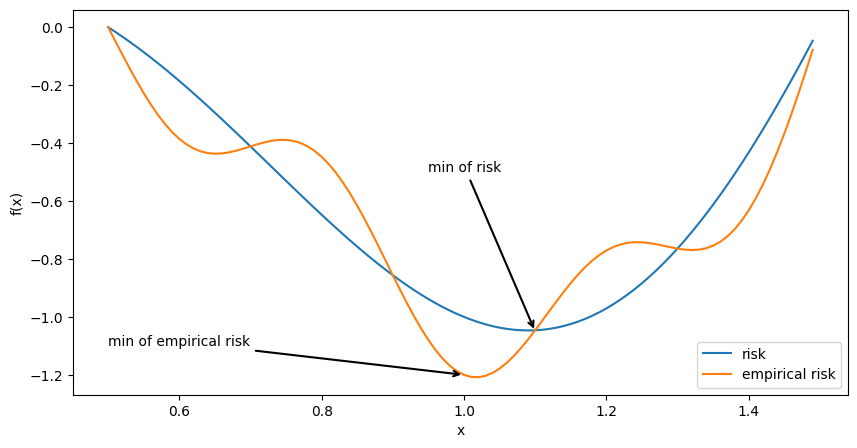

In [3]:
def annotate(text, xy, xytext):
    plt.gca().annotate(text, xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='->', lw=1.5))

x = torch.arange(0.5, 1.5, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='risk')
plt.plot(x, g(x), label='empirical risk')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('min of empirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

# Optimization Challenges

## Local Minima

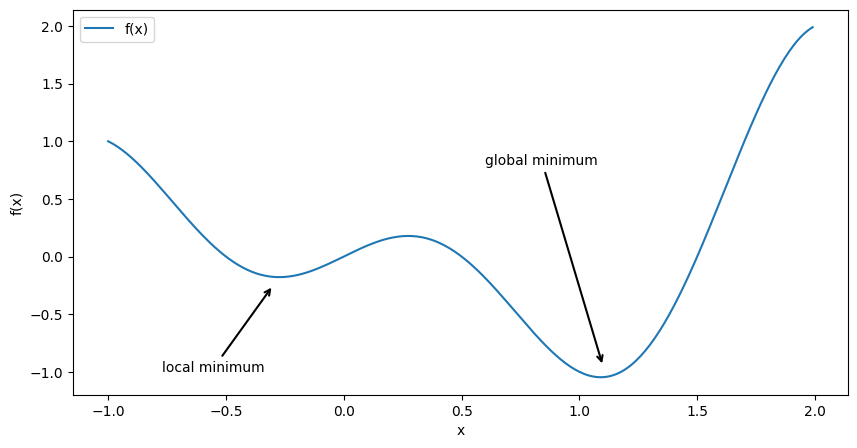

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

## Saddle Points

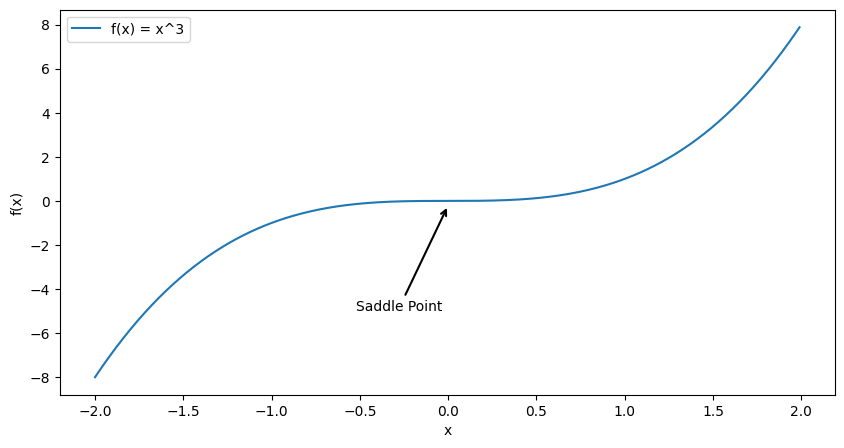

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, x**3, label='f(x) = x^3')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('Saddle Point', (0, -0.2), (-0.52, -5.0))

Saddle points in higher dimensions

c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.5, 'y')

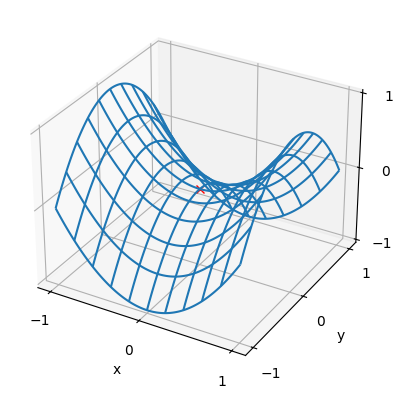

In [6]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y')

To differentiate between local minima, local maxima and saddle points in high dimensional data, we look at the hessian matrix at the zero-gradient position

## Vanishing Gradients

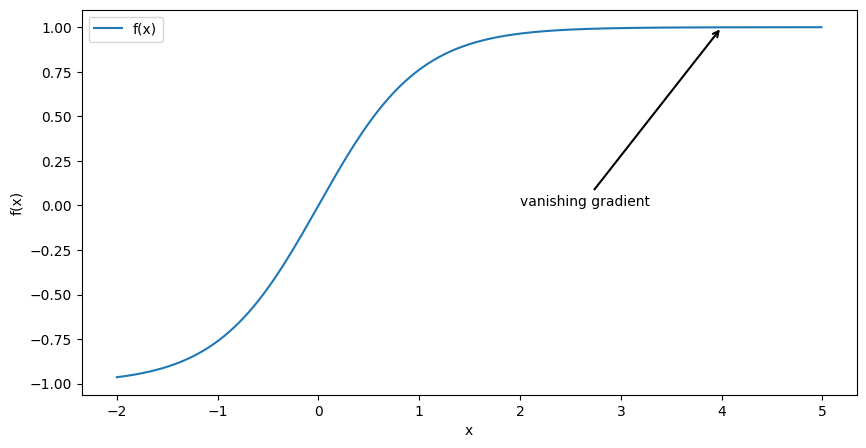

In [7]:
x = torch.arange(-2.0, 5.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, torch.tanh(x), label = 'f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('vanishing gradient', (4, 1), (2, 0.0))

# Convexity

## Convex Functions

In [8]:
f = lambda x: 0.5 * x**2 # Convex
g = lambda x: torch.cos(np.pi * x) # Non-convex
h = lambda x: torch.exp(0.5 * x) # Convex

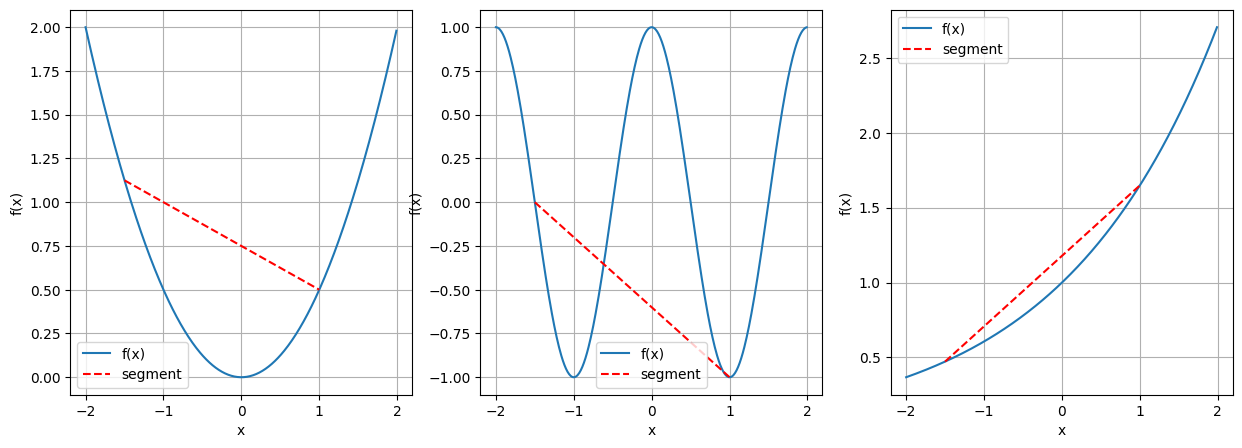

In [9]:
x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
_, ax = plt.subplots(1, 3, figsize=(15, 5))
for ax, func in zip(ax, [f, g, h]):
    ax.plot(x, func(x), label='f(x)')
    ax.plot(segment, func(segment), 'r--', label='segment')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.grid(True)

# Properties of Convex Functions

## Local Minima are Global Minima

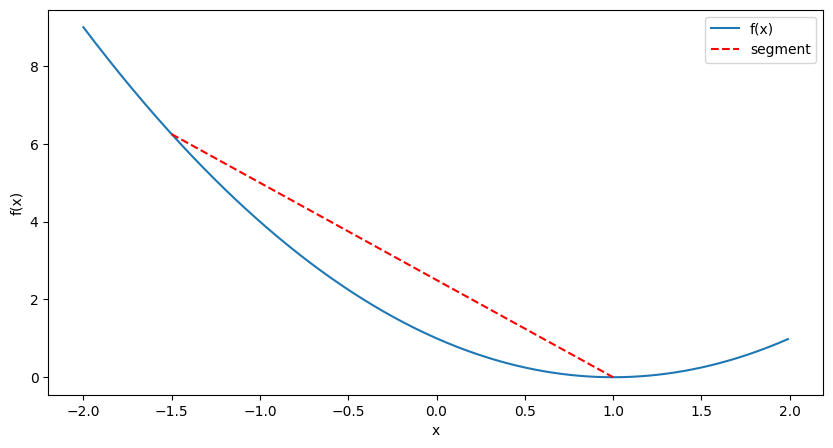

In [10]:
f = lambda x: (x - 1) ** 2
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='f(x)')
plt.plot(segment, f(segment), 'r--', label='segment')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

This property ensures that we do not get stuck when one or more minima exists. There are cases where there is no minima over a certain range

# Gradient Descent

In [11]:
def f(x):
    return x ** 2

def f_grad(x):
    return 2 * x

In [12]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x = {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x = 0.060466


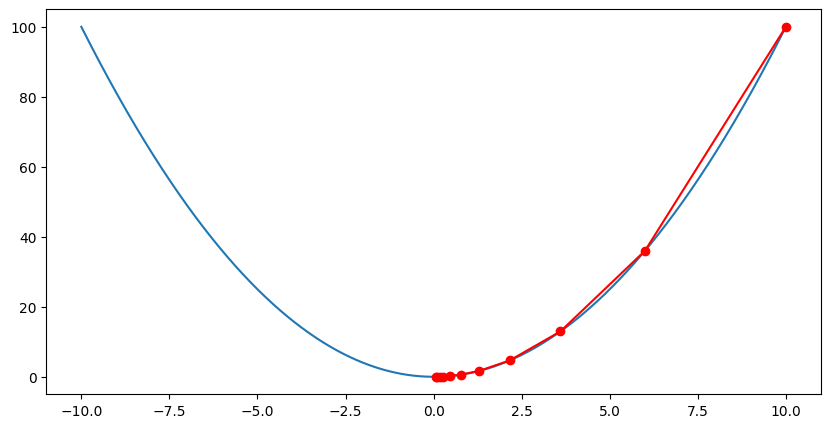

In [13]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(10, 5))
    plt.plot(f_line, f(f_line), label='f(x)')
    plt.plot(results, f(torch.tensor(results)), 'ro-', label='trace')
    plt.show()

show_trace(results, f)

## Learning Rate

epoch 10, x = 3.486784


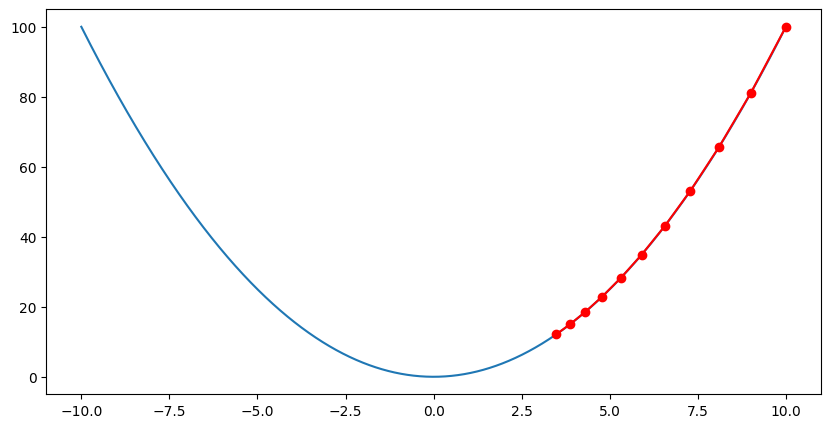

In [14]:
show_trace(gd(0.05, f_grad), f)

The above example shows an instance where the learning rate is too slow and thus does not reach the minima

epoch 10, x = 61.917364


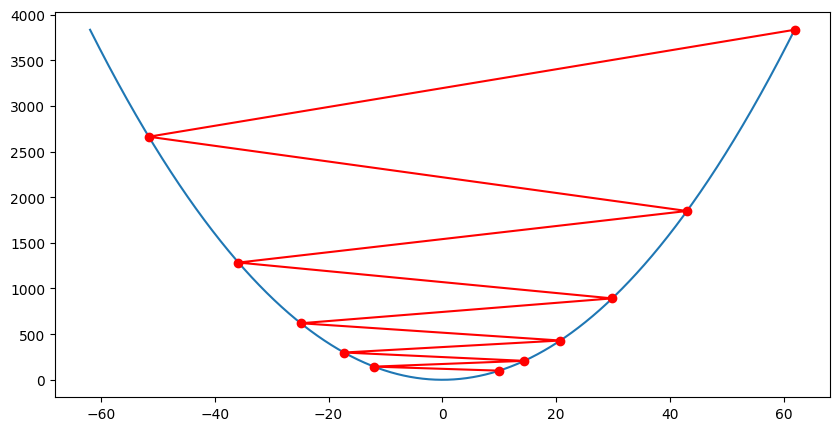

In [15]:
show_trace(gd(1.1, f_grad), f)

The above example shows an isntance where the learning rate is too fast and may or may not reach the minima

## Local Minima

epoch 10, x = -1.528166


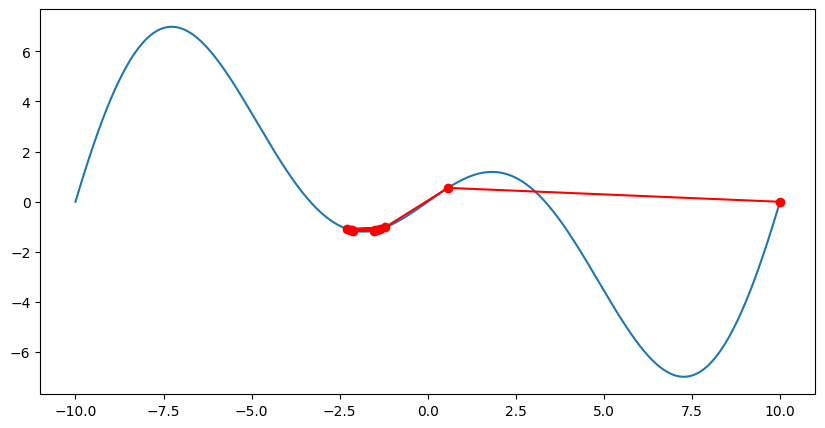

In [16]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

Above is an example of a nonconvex function which has many local minima. The choice of learning rate and how well conditioned the problem is, we may end up with many solutions. A high learning rate can lead to a poor local minimum

# Multivariate Gradient Descent

In [17]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(10, 5))
    plt.title('2D Optimization Trace')
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1), indexing='ij')
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


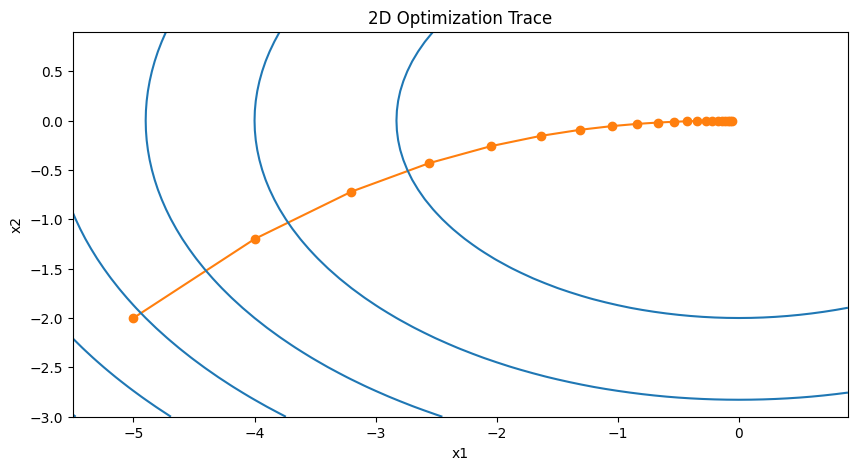

In [18]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

# Adaptive Methods

## Newton's Method

Newton's method on a convex function

epoch 10, x: tensor(0.)


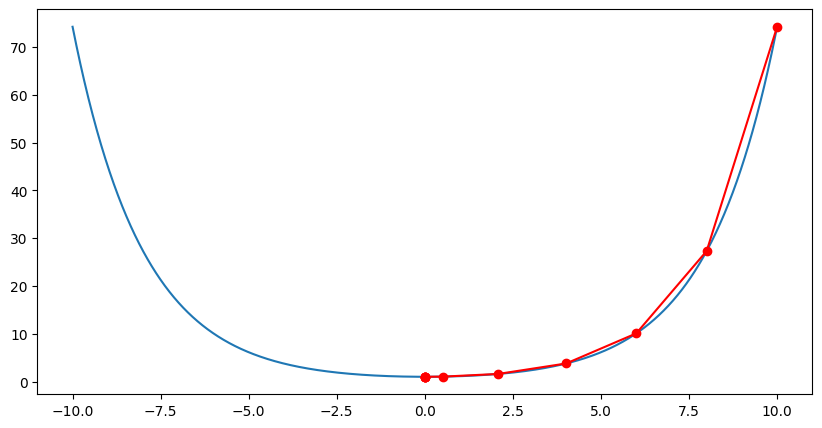

In [19]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

Newton's method on a nonconvex function

epoch 10, x: tensor(26.8341)


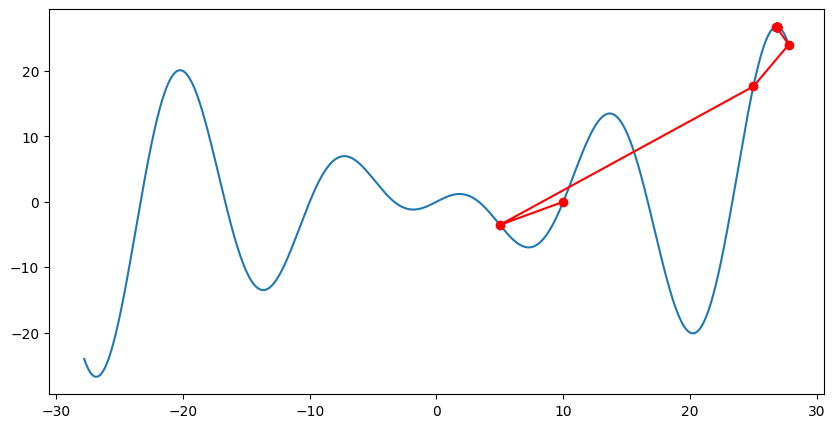

In [20]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

epoch 10, x: tensor(7.2699)


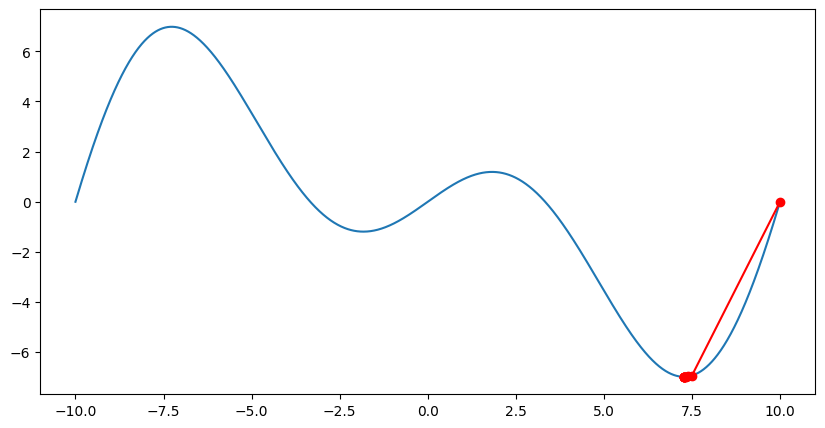

In [21]:
show_trace(newton(0.5), f)

# Stochastic Gradient Descent

Instead of incurring a cost of O(n) to calculate the gradient of the objective function, we can use the stochastic gradient as a good estimate of the gradient and bring down the computational cost to O(1) i.e. a significant improvement

epoch 50, x1: -0.201508, x2: -0.091351


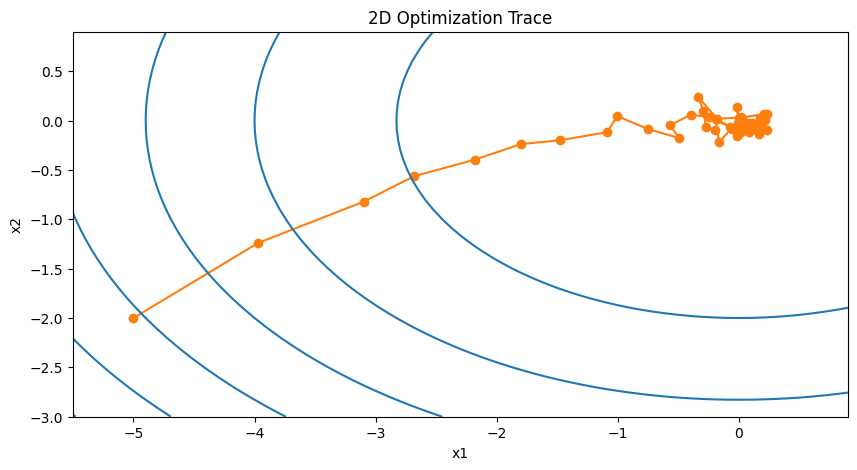

In [22]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_grad))

The trajectory of the variables in SGD is much more noisy than the ones we observed in Gradient Descent

## Dynamic Learning Rate

epoch 1000, x1: -0.729313, x2: -0.028798


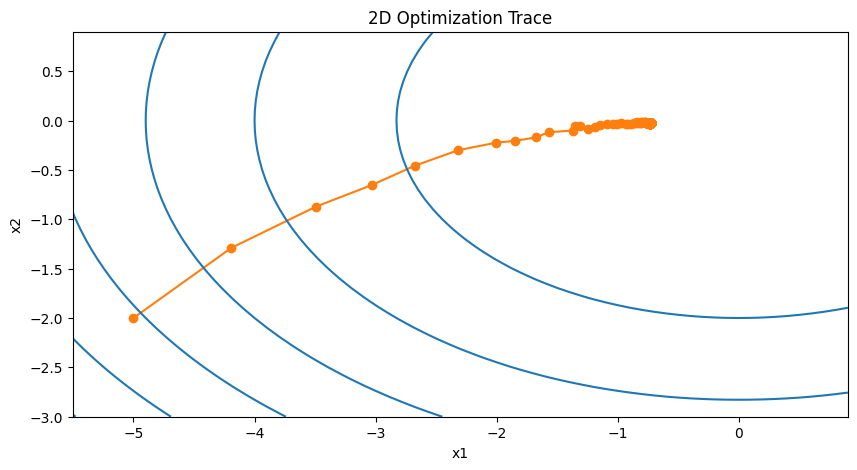

In [24]:
def exponential_lr():
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
show_trace_2d(f, train_2d(sgd, steps=1000, f_grad=f_grad))